# DDPM

In [113]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import fastcore.all as fc
from functools import partial

import torch
from torch import optim
from torch.nn import init
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
import torch.nn.functional as F

from minai.conv import def_device
from minai.datasets import inplace, show_images, show_image
from minai.learner import DataLoaders, TrainCB, ProgressCB, MetricsCB, Learner, DeviceCB, Callback, TrainLearner
from minai.sgd import BatchSchedCB, BaseSchedCB, set_seed

## V1

In [2]:
dsd = load_dataset('fashion_mnist')

In [3]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
x, y = 'image', 'label'

@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32, 32)) for o in b[x]]

In [5]:
bs = 128
ds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(ds, bs)

In [6]:
xb, yb = next(iter(dls.train))

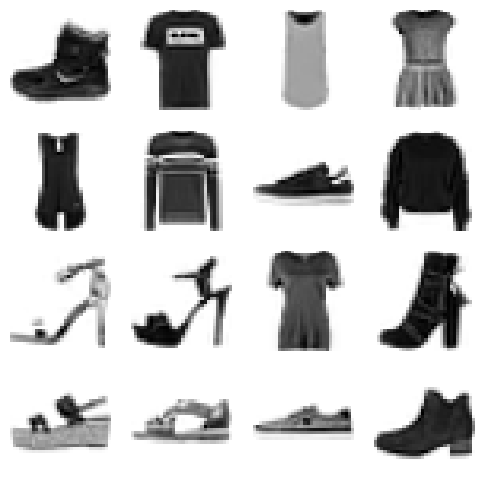

In [7]:
show_images(-xb[:16], imsize=1.5)

In [8]:
beta_min = 0.0001
beta_max = 0.02
n_steps = 1000
beta = torch.linspace(beta_min, beta_max, n_steps)
alpha = 1 - beta
sigma = beta.sqrt()
alphabar = alpha.cumprod(0)

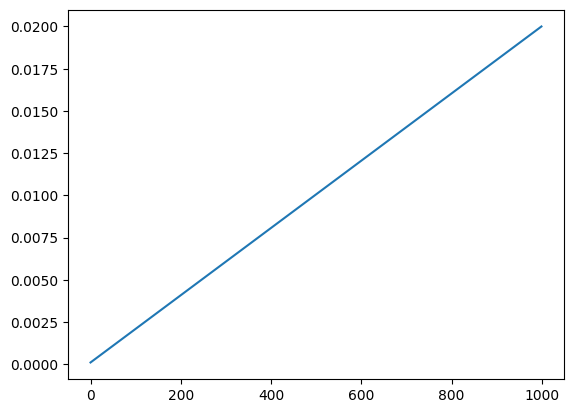

In [9]:
plt.plot(beta)

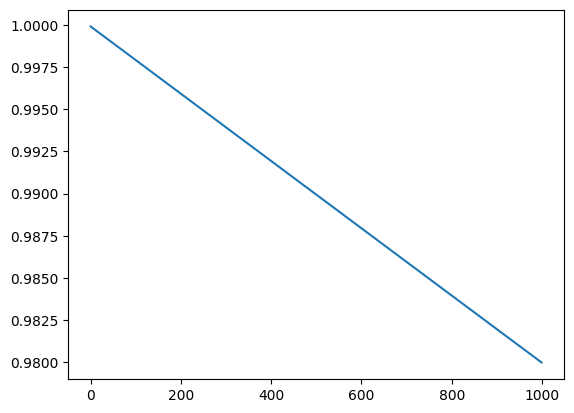

In [10]:
plt.plot(alpha)

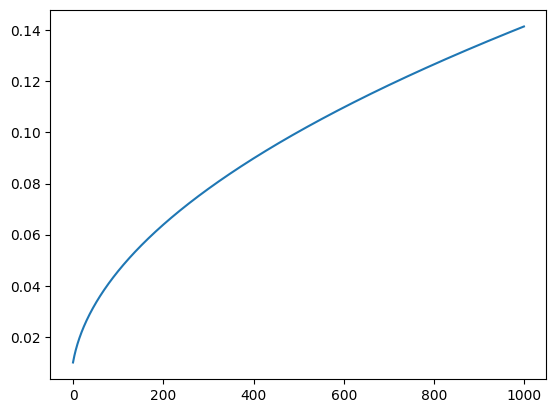

In [11]:
plt.plot(sigma)

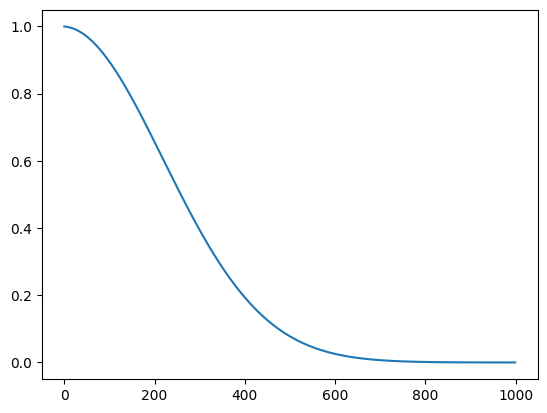

In [12]:
plt.plot(alphabar)

In [13]:
xb = next(iter(dls.train))

In [14]:
xb[0].shape

torch.Size([128, 1, 32, 32])

In [15]:
torch.randn((xb[0].shape)).shape

torch.Size([128, 1, 32, 32])

In [16]:
torch.randint(0, 1000, (128,))

tensor([205, 976, 901, 127, 236, 607,  27, 696, 979, 835, 479, 830, 819, 568, 513, 212, 596, 585, 683, 913, 421, 866, 538,
         16, 264, 874, 861, 997, 857, 615, 630, 959, 645, 647, 408, 286, 497, 352, 743, 252, 561, 682, 474, 941, 734, 992,
        801, 499, 118,  95, 986, 346, 337, 721,  72, 703, 655, 349, 389, 339, 687, 686, 706, 161,  47, 202,  94, 111, 659,
        925, 807, 949, 502, 380, 404, 691, 657,  52, 486, 926,  41, 776, 594, 958, 719, 904, 239, 366, 366,   4, 732, 665,
        428, 657, 739, 372,  27, 515, 189, 802,  53, 105, 819, 714, 172, 844, 891, 885, 444, 185, 710, 484, 896, 660, 811,
        490, 985, 417, 450, 137, 671, 701, 971, 307, 954, 731, 296, 611])

In [17]:
alphabar.shape

torch.Size([1000])

In [29]:
def noisify(x0, alphabar):
    x0 = x0.to(def_device)
    alphabar = alphabar.to(def_device)
    epsilon = torch.randn(x0.shape, device=def_device)
    t = torch.randint(0, alphabar.shape[0], (x0.shape[0],), device=def_device)
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1)
    x_t = alphabar_t.sqrt() * x0 + (1 - alphabar_t).sqrt() * epsilon
    return (x_t, t), epsilon

In [30]:
xb[0].shape

torch.Size([128, 1, 32, 32])

In [34]:
(noise_samples, t), _ = noisify(xb[0], alphabar)

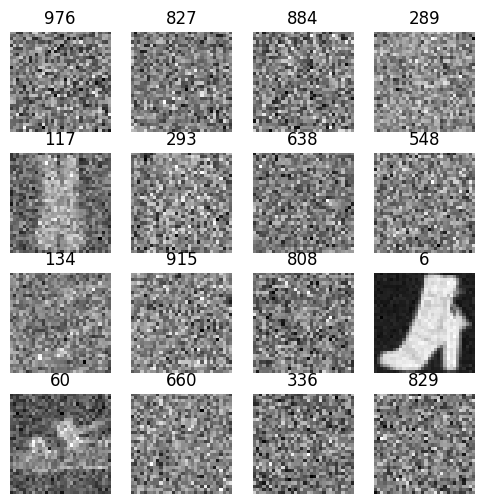

In [35]:
titles = fc.map_ex(t, '{}')
show_images(noise_samples[:16], imsize=1.5, titles=titles[:16])

In [36]:
alphabar[0]

tensor(1.00)

In [82]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    print('calling 1st version of sample')
    x_t = torch.randn(sz, device=def_device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=def_device, dtype=torch.long)
        z = torch.randn(sz, device=def_device) if t > 0 else torch.zeros(sz, device=def_device)
        alphabar_t_1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        alpha_t = alpha[t]
        beta_t = 1 - alpha_t
        alphabar_t = alphabar[t]
        noise = model(x_t, t).sample
        x0_coeff = (alphabar_t_1.sqrt() * beta_t) / (1 - alphabar[t])
        x0 = (1/(alphabar_t.sqrt())* (x_t - (1-alphabar_t).sqrt() * noise)).clamp(-1, 1)
        x_t_coeff = alpha_t.sqrt() * (1 - alphabar_t_1) / (1 - alphabar[t])
        x_t = x0 * x0_coeff + x_t_coeff * x_t + sigma[t] * z
        preds.append(x_t.cpu())
    return preds

In [83]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    print('calling 2nd version of sample')
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alpha_t = alpha[t]
        alphabar_t = alphabar[t]
        noise_pred = model(x_t, t_batch).sample
        
        term1 = (x_t - ((1 - alpha_t) / (1 - alphabar_t).sqrt()) * noise_pred)
        term2 = sigma[t] * z
        
        x_t = 1 / alpha_t.sqrt() * term1 + term2
        preds.append(x_t.cpu())
    return preds

In [84]:
class DDPMCB(TrainCB):
    def __init__(self, beta_min, beta_max, n_steps):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.n_steps = n_steps
        self.beta = torch.linspace(beta_min, beta_max, n_steps)
        self.alpha = 1 - beta
        self.sigma = self.beta.sqrt()
        self.alphabar = self.alpha.cumprod(0)
    
    def before_batch(self, learn):
        (xt_t, t), epsilon = noisify(learn.batch[0], self.alphabar)
        learn.batch = ((xt_t, t), epsilon)

    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[0]).sample

    def sample(self, model, sz):
        return sample(model, sz, self.alpha, self.alphabar, self.sigma, self.n_steps)

In [43]:
from diffusers import  UNet2DModel

In [44]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

In [45]:
set_seed(42)
lr = 4e-3
epochs = 5
ddpm_cb = DDPMCB(beta_min, beta_max, n_steps)
sched = partial(lr_scheduler.OneCycleLR, max_lr = lr, total_steps = len(dls.train) * epochs) 
cbs = [DeviceCB(), ddpm_cb, MetricsCB(), ProgressCB(plot=True), BatchSchedCB(sched)]
learn = Learner(model, dls, F.mse_loss, cbs=cbs, lr=lr, opt_func=optim.Adam)

loss,epoch,train
0.062,0,True
0.024,0,False
0.022,1,True
0.020,1,False
0.019,2,True
0.018,2,False
0.017,3,True
0.017,3,False
0.016,4,True
0.016,4,False


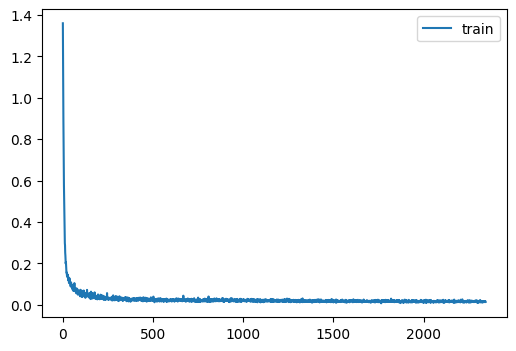

In [46]:
learn.fit(epochs)

In [48]:
mdl_path = fc.Path('models')
mdl_path.mkdir(exist_ok=True)

In [49]:
torch.save(learn.model, mdl_path/'fashion_mnist_ddpm.pkl')

In [50]:
learn.model = torch.load(mdl_path/'fashion_mnist_ddpm.pkl')

In [85]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

calling 2nd version of sample


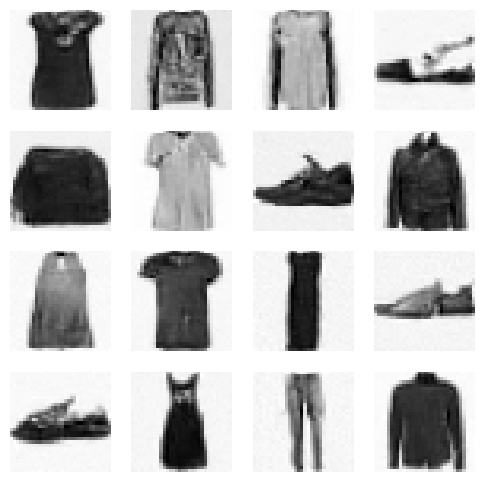

In [86]:
show_images(-samples[-1], imsize=1.5)

## V2

In [115]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    print('calling 1st version of sample')
    x_t = torch.randn(sz, device=def_device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=def_device, dtype=torch.long)
        z = torch.randn(sz, device=def_device) if t > 0 else torch.zeros(sz, device=def_device)
        alphabar_t_1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        alpha_t = alpha[t]
        beta_t = 1 - alpha_t
        alphabar_t = alphabar[t]
        noise = model((x_t, t))
        x0_coeff = (alphabar_t_1.sqrt() * beta_t) / (1 - alphabar[t])
        x0 = (1/(alphabar_t.sqrt())* (x_t - (1-alphabar_t).sqrt() * noise)).clamp(-1, 1)
        x_t_coeff = alpha_t.sqrt() * (1 - alphabar_t_1) / (1 - alphabar[t])
        x_t = x0 * x0_coeff + x_t_coeff * x_t + sigma[t] * z
        preds.append(x_t.cpu())
    return preds

In [89]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    print('calling 2nd version of sample')
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alpha_t = alpha[t]
        alphabar_t = alphabar[t]
        noise_pred = model((x_t, t_batch))
        
        term1 = (x_t - ((1 - alpha_t) / (1 - alphabar_t).sqrt()) * noise_pred)
        term2 = sigma[t] * z
        
        x_t = 1 / alpha_t.sqrt() * term1 + term2
        preds.append(x_t.cpu())
    return preds

In [90]:
class DDPMCB_v2(Callback):
    def __init__(self, beta_min, beta_max, n_steps):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.n_steps = n_steps
        self.beta = torch.linspace(beta_min, beta_max, n_steps)
        self.alpha = 1 - beta
        self.sigma = self.beta.sqrt()
        self.alphabar = self.alpha.cumprod(0)
    
    def before_batch(self, learn):
        (xt_t, t), epsilon = noisify(learn.batch[0], self.alphabar)
        learn.batch = ((xt_t, t), epsilon)

    def sample(self, model, sz):
        return sample(model, sz, self.alpha, self.alphabar, self.sigma, self.n_steps)

In [91]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [93]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [98]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [99]:
init_ddpm(model)

In [105]:
set_seed(42)
lr = 5e-3
epochs = 5
ddpm_cb = DDPMCB_v2(beta_min, beta_max, n_steps)
sched = partial(lr_scheduler.OneCycleLR, max_lr = lr, total_steps = len(dls.train) * epochs) 
cbs = [DeviceCB(), ddpm_cb, MetricsCB(), ProgressCB(plot=True), BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.mse_loss, cbs=cbs, lr=lr, opt_func=partial(optim.Adam, eps=1e-5))

loss,epoch,train
0.146,0,True
0.025,0,False
0.021,1,True
0.021,1,False
0.019,2,True
0.017,2,False
0.017,3,True
0.017,3,False
0.016,4,True
0.016,4,False


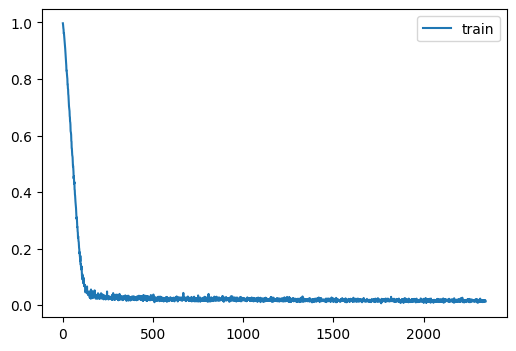

In [106]:
learn.fit(epochs)

In [107]:
torch.save(learn.model, mdl_path/'fashion_mnist_ddpm_v2.pkl')

In [116]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

calling 1st version of sample


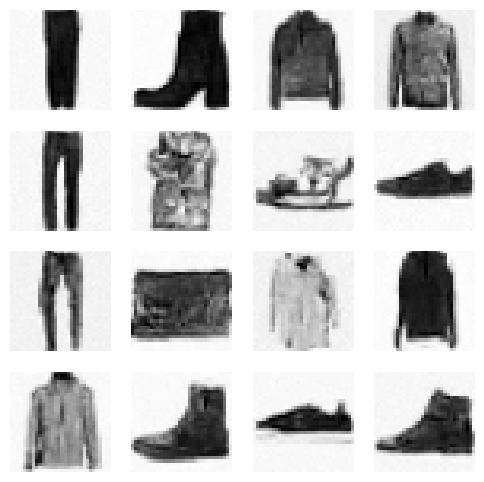

In [119]:
show_images(-samples[-1], imsize=1.5) 

Using matplotlib backend: module://matplotlib_inline.backend_inline


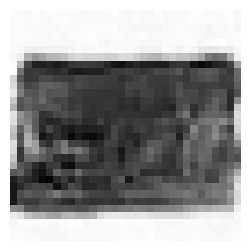

In [118]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = fc.L.range(800,990, 5)+fc.L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))